In [1]:
!pip install huggingface_hub transformers diffusers peft accelerate protobuf sentencepiece wandb bitsandbytes typing-extensions==4.12.2 matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 139.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 410.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 148.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 329.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 206.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 229.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 232.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 363.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 402.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 315.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 355.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 kB 220.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from huggingface_hub import notebook_login
notebook_login()

Plot saved to /workspace/sdxl_results/short_prompts/correlation_results_stable-diffusion-xl-base-1.0_plot.png


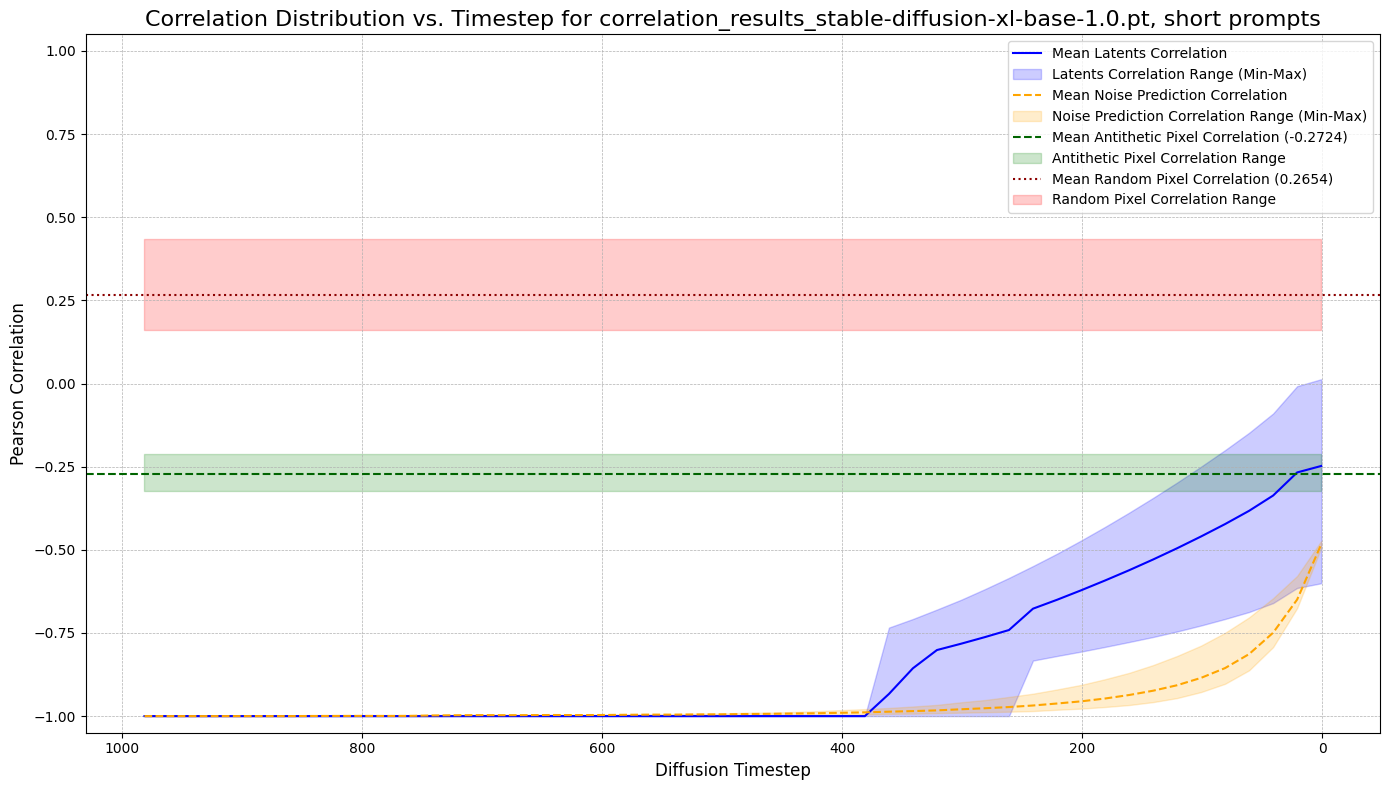

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import argparse
import os

file_path = '/workspace/sdxl_results/short_prompts/correlation_results_stable-diffusion-xl-base-1.0.pt'
# Load the data from the PyTorch file
data = torch.load(file_path)

# --- Aggregate Data Across All Prompts ---
latents_correlations_by_timestep = defaultdict(list)
noise_pred_correlations_by_timestep = defaultdict(list)
pixel_anti_correlations = []
pixel_random_correlations = []

for prompt, values in data.items():
    if values.get('latents'):
        for t, corr in values['latents']:
            latents_correlations_by_timestep[t.item()].append(corr.item())
    
    if values.get('noise_pred'):
        for t, corr in values['noise_pred']:
            noise_pred_correlations_by_timestep[t.item()].append(corr.item())

    if values.get('pixel_anti') is not None:
        pixel_anti_correlations.append(values['pixel_anti'].item())
        
    if values.get('pixel_random') is not None:
        pixel_random_correlations.append(values['pixel_random'].item())

# --- Calculate Statistics for Plotting ---

# For latents
latents_timesteps = sorted(latents_correlations_by_timestep.keys(), reverse=True)
latents_mean = [np.mean(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_min = [np.min(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_max = [np.max(latents_correlations_by_timestep[t]) for t in latents_timesteps]

# For noise_pred
noise_pred_timesteps = sorted(noise_pred_correlations_by_timestep.keys(), reverse=True)
noise_pred_mean = [np.mean(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_min = [np.min(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_max = [np.max(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]

# --- Create the Plot ---
plt.figure(figsize=(14, 8))

# Plot Latents Correlation Distribution
plt.plot(latents_timesteps, latents_mean, color='blue', linestyle='-', label='Mean Latents Correlation')
plt.fill_between(latents_timesteps, latents_min, latents_max, color='blue', alpha=0.2, label='Latents Correlation Range (Min-Max)')

# Plot Noise Prediction Correlation Distribution
plt.plot(noise_pred_timesteps, noise_pred_mean, color='orange', linestyle='--', label='Mean Noise Prediction Correlation')
plt.fill_between(noise_pred_timesteps, noise_pred_min, noise_pred_max, color='orange', alpha=0.2, label='Noise Prediction Correlation Range (Min-Max)')

# Plot Pixel-Level Correlation Distributions as horizontal bands
if pixel_anti_correlations:
    mean_anti = np.mean(pixel_anti_correlations)
    min_anti = np.min(pixel_anti_correlations)
    max_anti = np.max(pixel_anti_correlations)
    plt.axhline(y=mean_anti, color='darkgreen', linestyle='--', label=f'Mean Antithetic Pixel Correlation ({mean_anti:.4f})')
    plt.fill_between(latents_timesteps, min_anti, max_anti, color='green', alpha=0.2, label='Antithetic Pixel Correlation Range')

if pixel_random_correlations:
    mean_random = np.mean(pixel_random_correlations)
    min_random = np.min(pixel_random_correlations)
    max_random = np.max(pixel_random_correlations)
    plt.axhline(y=mean_random, color='darkred', linestyle=':', label=f'Mean Random Pixel Correlation ({mean_random:.4f})')
    plt.fill_between(latents_timesteps, min_random, max_random, color='red', alpha=0.2, label='Random Pixel Correlation Range')


# --- Configure the Plot ---
plt.title(f'Correlation Distribution vs. Timestep for {os.path.basename(file_path)}, short prompts', fontsize=16)
plt.xlabel('Diffusion Timestep', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.ylim(-1.05, 1.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Reverse the x-axis
ax = plt.gca()
ax.invert_xaxis()

plt.legend(fontsize=10)
plt.tight_layout()

# Save the plot
plot_save_path = f"{os.path.splitext(file_path)[0]}_plot.png"
plt.savefig(plot_save_path)
print(f"Plot saved to {plot_save_path}")
plt.show()

Plot saved to /workspace/sdxl_results/long_prompts/correlation_results_stable-diffusion-xl-base-1.0_plot.png


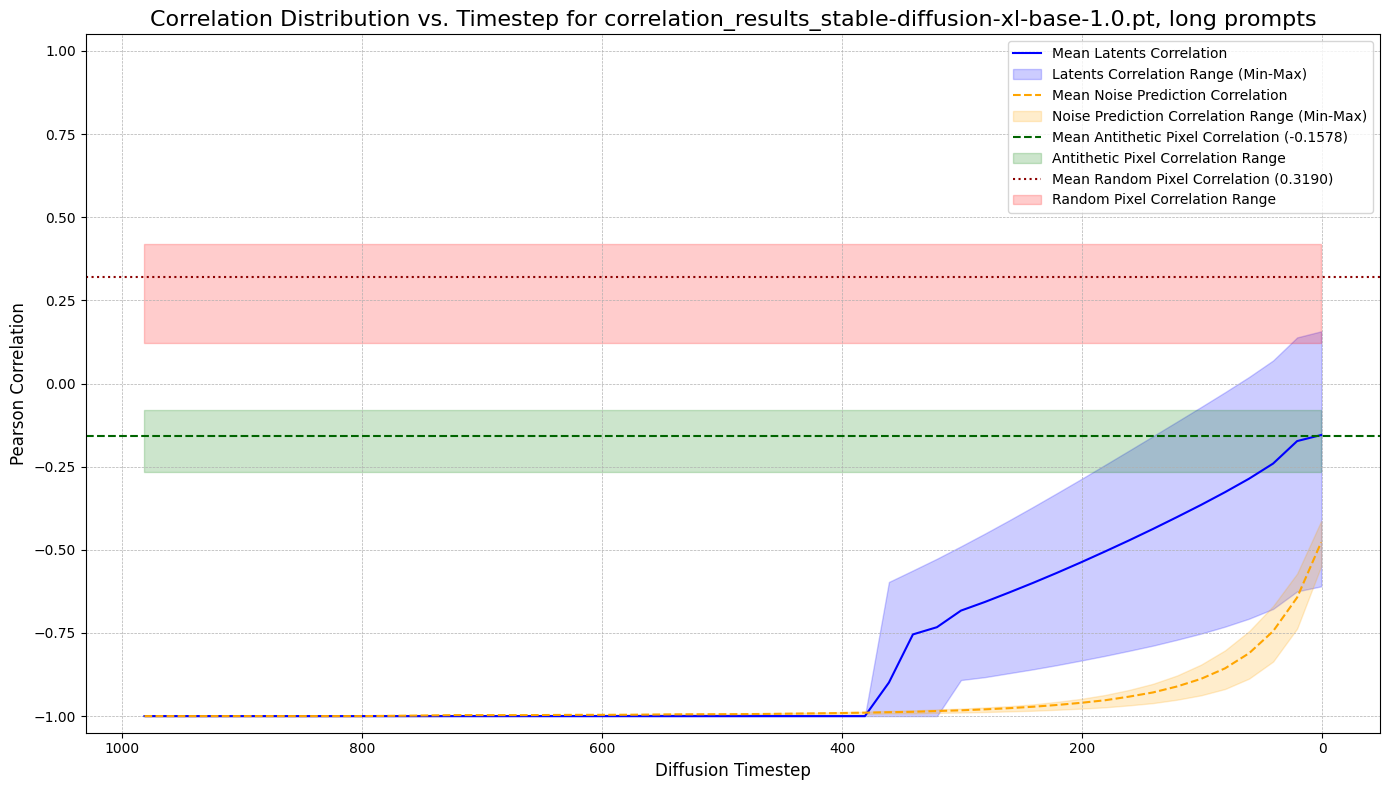

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import argparse
import os

file_path = '/workspace/sdxl_results/long_prompts/correlation_results_stable-diffusion-xl-base-1.0.pt'
# Load the data from the PyTorch file
data = torch.load(file_path)

# --- Aggregate Data Across All Prompts ---
latents_correlations_by_timestep = defaultdict(list)
noise_pred_correlations_by_timestep = defaultdict(list)
pixel_anti_correlations = []
pixel_random_correlations = []

for prompt, values in data.items():
    if values.get('latents'):
        for t, corr in values['latents']:
            latents_correlations_by_timestep[t.item()].append(corr.item())
    
    if values.get('noise_pred'):
        for t, corr in values['noise_pred']:
            noise_pred_correlations_by_timestep[t.item()].append(corr.item())

    if values.get('pixel_anti') is not None:
        pixel_anti_correlations.append(values['pixel_anti'].item())
        
    if values.get('pixel_random') is not None:
        pixel_random_correlations.append(values['pixel_random'].item())

# --- Calculate Statistics for Plotting ---

# For latents
latents_timesteps = sorted(latents_correlations_by_timestep.keys(), reverse=True)
latents_mean = [np.mean(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_min = [np.min(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_max = [np.max(latents_correlations_by_timestep[t]) for t in latents_timesteps]

# For noise_pred
noise_pred_timesteps = sorted(noise_pred_correlations_by_timestep.keys(), reverse=True)
noise_pred_mean = [np.mean(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_min = [np.min(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_max = [np.max(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]

# --- Create the Plot ---
plt.figure(figsize=(14, 8))

# Plot Latents Correlation Distribution
plt.plot(latents_timesteps, latents_mean, color='blue', linestyle='-', label='Mean Latents Correlation')
plt.fill_between(latents_timesteps, latents_min, latents_max, color='blue', alpha=0.2, label='Latents Correlation Range (Min-Max)')

# Plot Noise Prediction Correlation Distribution
plt.plot(noise_pred_timesteps, noise_pred_mean, color='orange', linestyle='--', label='Mean Noise Prediction Correlation')
plt.fill_between(noise_pred_timesteps, noise_pred_min, noise_pred_max, color='orange', alpha=0.2, label='Noise Prediction Correlation Range (Min-Max)')

# Plot Pixel-Level Correlation Distributions as horizontal bands
if pixel_anti_correlations:
    mean_anti = np.mean(pixel_anti_correlations)
    min_anti = np.min(pixel_anti_correlations)
    max_anti = np.max(pixel_anti_correlations)
    plt.axhline(y=mean_anti, color='darkgreen', linestyle='--', label=f'Mean Antithetic Pixel Correlation ({mean_anti:.4f})')
    plt.fill_between(latents_timesteps, min_anti, max_anti, color='green', alpha=0.2, label='Antithetic Pixel Correlation Range')

if pixel_random_correlations:
    mean_random = np.mean(pixel_random_correlations)
    min_random = np.min(pixel_random_correlations)
    max_random = np.max(pixel_random_correlations)
    plt.axhline(y=mean_random, color='darkred', linestyle=':', label=f'Mean Random Pixel Correlation ({mean_random:.4f})')
    plt.fill_between(latents_timesteps, min_random, max_random, color='red', alpha=0.2, label='Random Pixel Correlation Range')


# --- Configure the Plot ---
plt.title(f'Correlation Distribution vs. Timestep for {os.path.basename(file_path)}, long prompts', fontsize=16)
plt.xlabel('Diffusion Timestep', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.ylim(-1.05, 1.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Reverse the x-axis
ax = plt.gca()
ax.invert_xaxis()

plt.legend(fontsize=10)
plt.tight_layout()

# Save the plot
plot_save_path = f"{os.path.splitext(file_path)[0]}_plot.png"
plt.savefig(plot_save_path)
print(f"Plot saved to {plot_save_path}")
plt.show()

Plot saved to /workspace/wan_results/short_prompts/correlation_results_Wan2.1-T2V-14B-Diffusers_plot.png


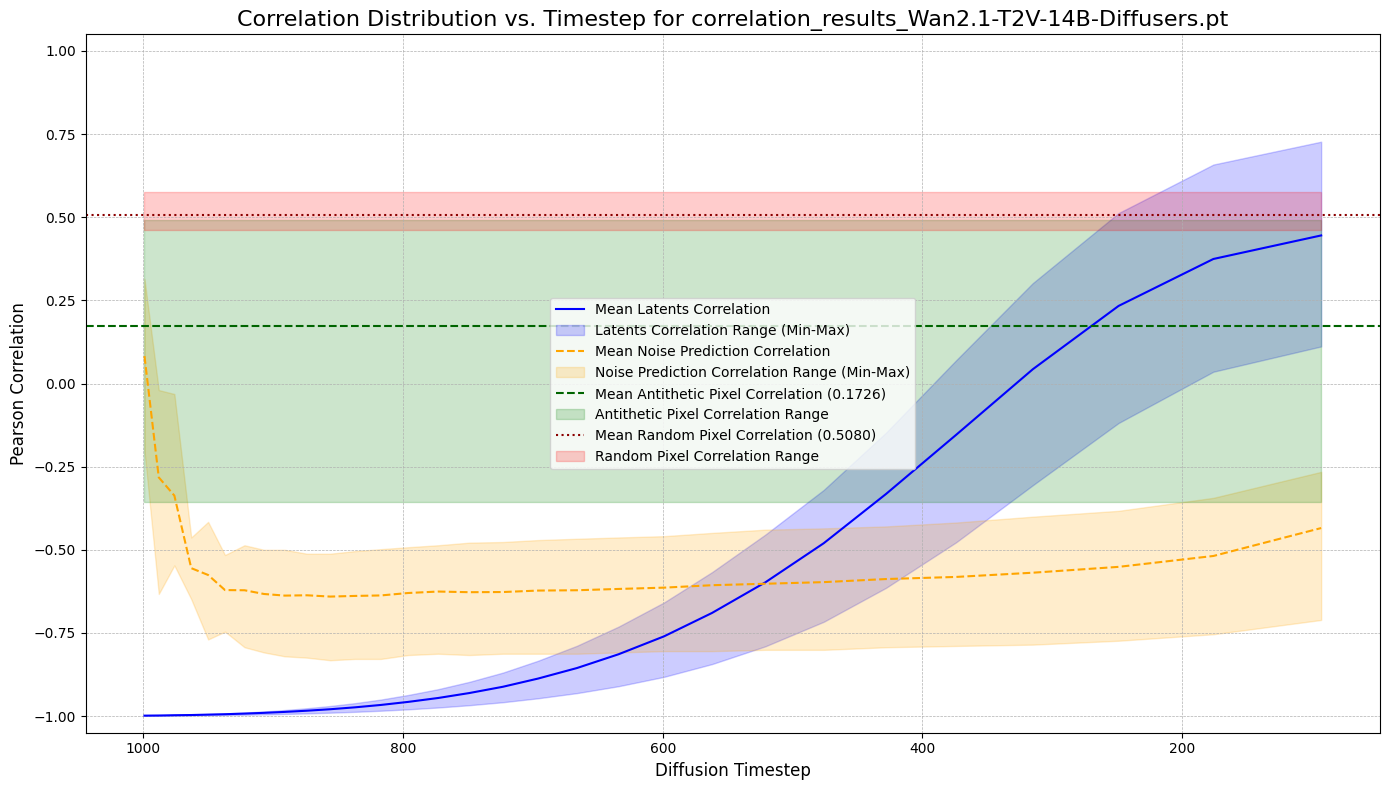

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import argparse
import os

file_path = '/workspace/wan_results/short_prompts/correlation_results_Wan2.1-T2V-14B-Diffusers.pt'
# Load the data from the PyTorch file
data = torch.load(file_path)

# --- Aggregate Data Across All Prompts ---
latents_correlations_by_timestep = defaultdict(list)
noise_pred_correlations_by_timestep = defaultdict(list)
pixel_anti_correlations = []
pixel_random_correlations = []

for prompt, values in data.items():
    if values.get('latents'):
        for t, corr in values['latents']:
            latents_correlations_by_timestep[t.item()].append(corr.item())
    
    if values.get('noise_pred'):
        for t, corr in values['noise_pred']:
            noise_pred_correlations_by_timestep[t.item()].append(corr.item())

    if values.get('pixel_anti') is not None:
        pixel_anti_correlations.append(values['pixel_anti'].item())
        
    if values.get('pixel_random') is not None:
        pixel_random_correlations.append(values['pixel_random'].item())

# --- Calculate Statistics for Plotting ---

# For latents
latents_timesteps = sorted(latents_correlations_by_timestep.keys(), reverse=True)
latents_mean = [np.mean(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_min = [np.min(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_max = [np.max(latents_correlations_by_timestep[t]) for t in latents_timesteps]

# For noise_pred
noise_pred_timesteps = sorted(noise_pred_correlations_by_timestep.keys(), reverse=True)
noise_pred_mean = [np.mean(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_min = [np.min(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_max = [np.max(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]

# --- Create the Plot ---
plt.figure(figsize=(14, 8))

# Plot Latents Correlation Distribution
plt.plot(latents_timesteps, latents_mean, color='blue', linestyle='-', label='Mean Latents Correlation')
plt.fill_between(latents_timesteps, latents_min, latents_max, color='blue', alpha=0.2, label='Latents Correlation Range (Min-Max)')

# Plot Noise Prediction Correlation Distribution
plt.plot(noise_pred_timesteps, noise_pred_mean, color='orange', linestyle='--', label='Mean Noise Prediction Correlation')
plt.fill_between(noise_pred_timesteps, noise_pred_min, noise_pred_max, color='orange', alpha=0.2, label='Noise Prediction Correlation Range (Min-Max)')

# Plot Pixel-Level Correlation Distributions as horizontal bands
if pixel_anti_correlations:
    mean_anti = np.mean(pixel_anti_correlations)
    min_anti = np.min(pixel_anti_correlations)
    max_anti = np.max(pixel_anti_correlations)
    plt.axhline(y=mean_anti, color='darkgreen', linestyle='--', label=f'Mean Antithetic Pixel Correlation ({mean_anti:.4f})')
    plt.fill_between(latents_timesteps, min_anti, max_anti, color='green', alpha=0.2, label='Antithetic Pixel Correlation Range')

if pixel_random_correlations:
    mean_random = np.mean(pixel_random_correlations)
    min_random = np.min(pixel_random_correlations)
    max_random = np.max(pixel_random_correlations)
    plt.axhline(y=mean_random, color='darkred', linestyle=':', label=f'Mean Random Pixel Correlation ({mean_random:.4f})')
    plt.fill_between(latents_timesteps, min_random, max_random, color='red', alpha=0.2, label='Random Pixel Correlation Range')


# --- Configure the Plot ---
plt.title(f'Correlation Distribution vs. Timestep for {os.path.basename(file_path)}', fontsize=16)
plt.xlabel('Diffusion Timestep', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.ylim(-1.05, 1.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Reverse the x-axis
ax = plt.gca()
ax.invert_xaxis()

plt.legend(fontsize=10)
plt.tight_layout()

# Save the plot
plot_save_path = f"{os.path.splitext(file_path)[0]}_plot.png"
plt.savefig(plot_save_path)
print(f"Plot saved to {plot_save_path}")
plt.show()

Plot saved to /workspace/wan_results/long_prompts/correlation_results_Wan2.1-T2V-14B-Diffusers_plot.png


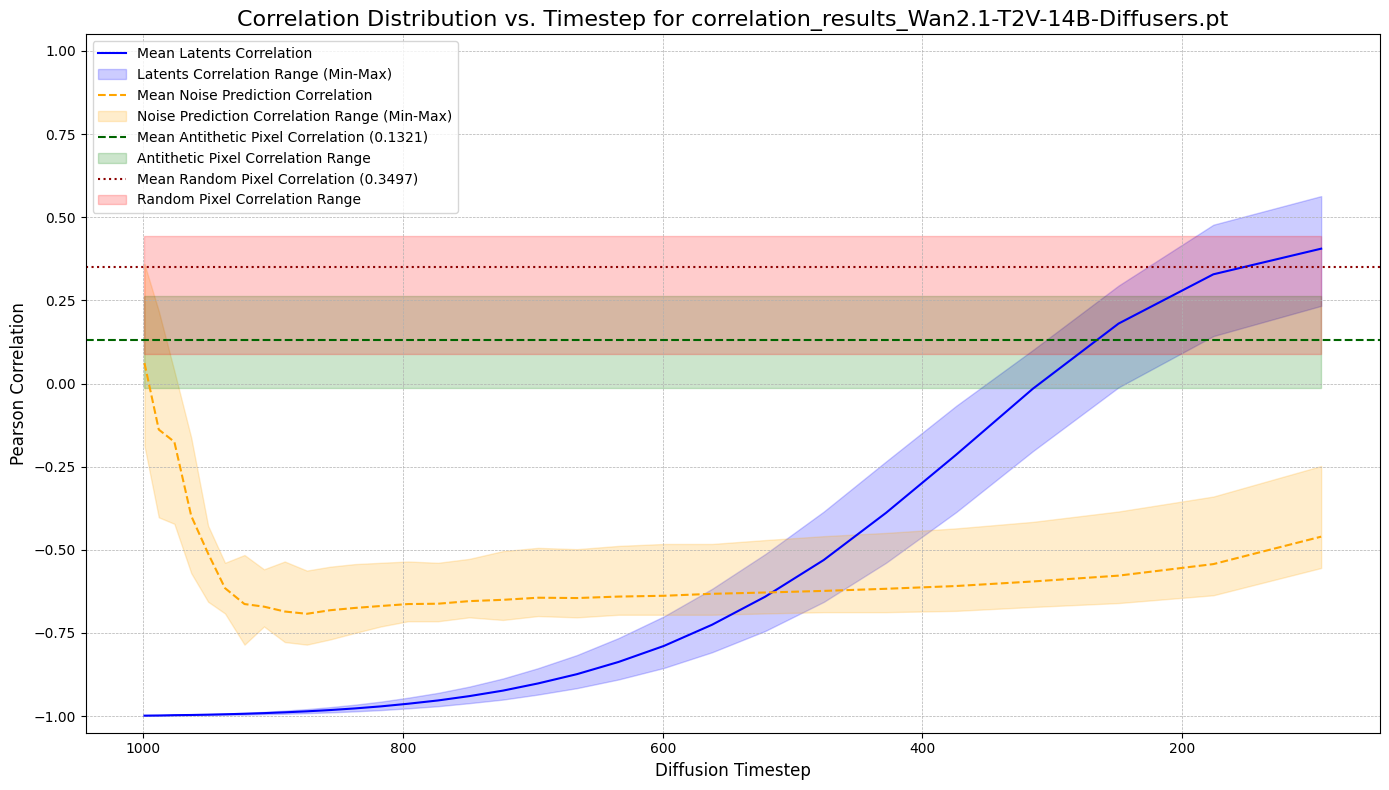

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import argparse
import os

file_path = '/workspace/wan_results/long_prompts/correlation_results_Wan2.1-T2V-14B-Diffusers.pt'
# Load the data from the PyTorch file
data = torch.load(file_path)

# --- Aggregate Data Across All Prompts ---
latents_correlations_by_timestep = defaultdict(list)
noise_pred_correlations_by_timestep = defaultdict(list)
pixel_anti_correlations = []
pixel_random_correlations = []

for prompt, values in data.items():
    if values.get('latents'):
        for t, corr in values['latents']:
            latents_correlations_by_timestep[t.item()].append(corr.item())
    
    if values.get('noise_pred'):
        for t, corr in values['noise_pred']:
            noise_pred_correlations_by_timestep[t.item()].append(corr.item())

    if values.get('pixel_anti') is not None:
        pixel_anti_correlations.append(values['pixel_anti'].item())
        
    if values.get('pixel_random') is not None:
        pixel_random_correlations.append(values['pixel_random'].item())

# --- Calculate Statistics for Plotting ---

# For latents
latents_timesteps = sorted(latents_correlations_by_timestep.keys(), reverse=True)
latents_mean = [np.mean(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_min = [np.min(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_max = [np.max(latents_correlations_by_timestep[t]) for t in latents_timesteps]

# For noise_pred
noise_pred_timesteps = sorted(noise_pred_correlations_by_timestep.keys(), reverse=True)
noise_pred_mean = [np.mean(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_min = [np.min(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_max = [np.max(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]

# --- Create the Plot ---
plt.figure(figsize=(14, 8))

# Plot Latents Correlation Distribution
plt.plot(latents_timesteps, latents_mean, color='blue', linestyle='-', label='Mean Latents Correlation')
plt.fill_between(latents_timesteps, latents_min, latents_max, color='blue', alpha=0.2, label='Latents Correlation Range (Min-Max)')

# Plot Noise Prediction Correlation Distribution
plt.plot(noise_pred_timesteps, noise_pred_mean, color='orange', linestyle='--', label='Mean Noise Prediction Correlation')
plt.fill_between(noise_pred_timesteps, noise_pred_min, noise_pred_max, color='orange', alpha=0.2, label='Noise Prediction Correlation Range (Min-Max)')

# Plot Pixel-Level Correlation Distributions as horizontal bands
if pixel_anti_correlations:
    mean_anti = np.mean(pixel_anti_correlations)
    min_anti = np.min(pixel_anti_correlations)
    max_anti = np.max(pixel_anti_correlations)
    plt.axhline(y=mean_anti, color='darkgreen', linestyle='--', label=f'Mean Antithetic Pixel Correlation ({mean_anti:.4f})')
    plt.fill_between(latents_timesteps, min_anti, max_anti, color='green', alpha=0.2, label='Antithetic Pixel Correlation Range')

if pixel_random_correlations:
    mean_random = np.mean(pixel_random_correlations)
    min_random = np.min(pixel_random_correlations)
    max_random = np.max(pixel_random_correlations)
    plt.axhline(y=mean_random, color='darkred', linestyle=':', label=f'Mean Random Pixel Correlation ({mean_random:.4f})')
    plt.fill_between(latents_timesteps, min_random, max_random, color='red', alpha=0.2, label='Random Pixel Correlation Range')


# --- Configure the Plot ---
plt.title(f'Correlation Distribution vs. Timestep for {os.path.basename(file_path)}', fontsize=16)
plt.xlabel('Diffusion Timestep', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.ylim(-1.05, 1.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Reverse the x-axis
ax = plt.gca()
ax.invert_xaxis()

plt.legend(fontsize=10)
plt.tight_layout()

# Save the plot
plot_save_path = f"{os.path.splitext(file_path)[0]}_plot.png"
plt.savefig(plot_save_path)
print(f"Plot saved to {plot_save_path}")
plt.show()

Plot saved to /workspace/flux_results/long_prompts/correlation_results_FLUX.1-schnell_plot.png


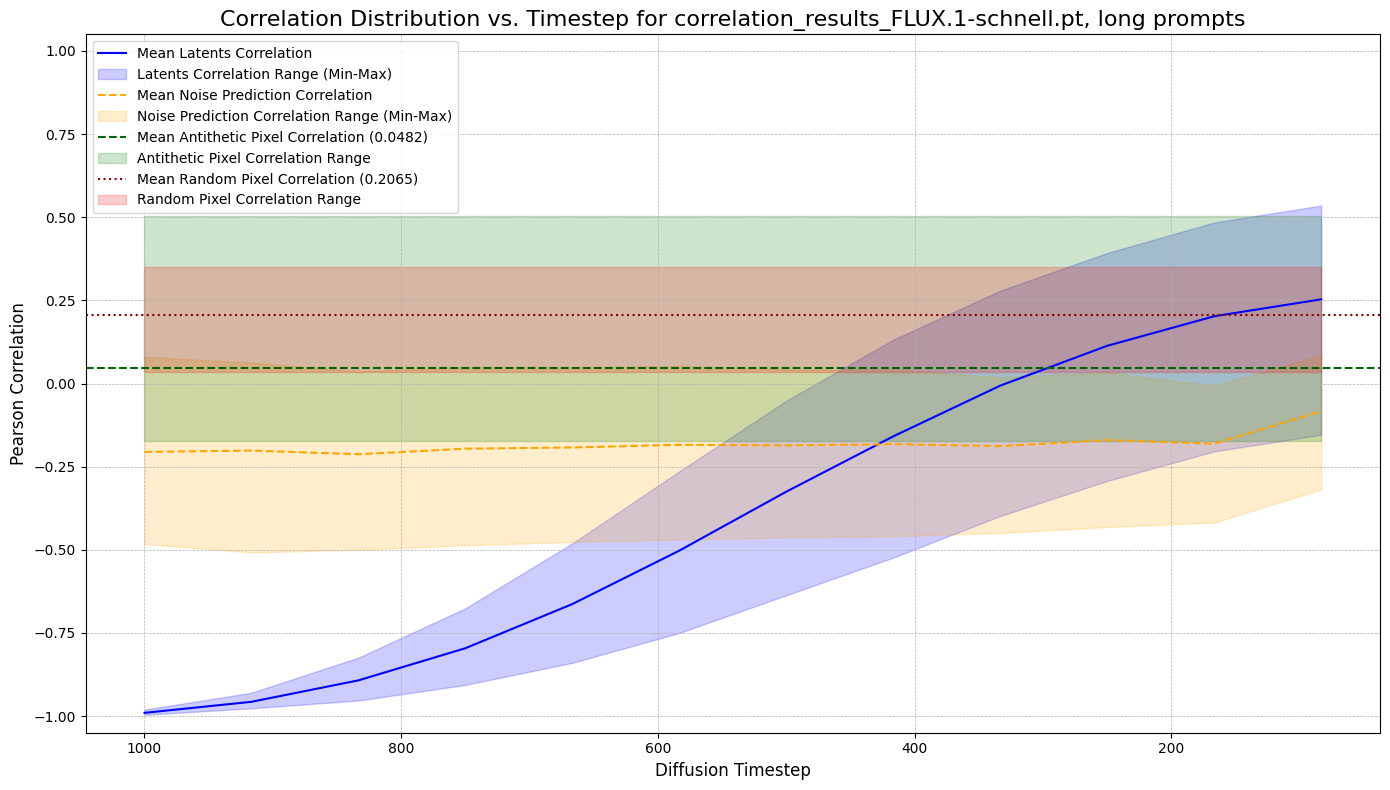

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import argparse
import os

file_path = '/workspace/flux_results/long_prompts/correlation_results_FLUX.1-schnell.pt'
# Load the data from the PyTorch file
data = torch.load(file_path)

# --- Aggregate Data Across All Prompts ---
latents_correlations_by_timestep = defaultdict(list)
noise_pred_correlations_by_timestep = defaultdict(list)
pixel_anti_correlations = []
pixel_random_correlations = []

for prompt, values in data.items():
    if values.get('latents'):
        for t, corr in values['latents']:
            latents_correlations_by_timestep[t.item()].append(corr.item())
    
    if values.get('noise_pred'):
        for t, corr in values['noise_pred']:
            noise_pred_correlations_by_timestep[t.item()].append(corr.item())

    if values.get('pixel_anti') is not None:
        pixel_anti_correlations.append(values['pixel_anti'].item())
        
    if values.get('pixel_random') is not None:
        pixel_random_correlations.append(values['pixel_random'].item())

# --- Calculate Statistics for Plotting ---

# For latents
latents_timesteps = sorted(latents_correlations_by_timestep.keys(), reverse=True)
latents_mean = [np.mean(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_min = [np.min(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_max = [np.max(latents_correlations_by_timestep[t]) for t in latents_timesteps]

# For noise_pred
noise_pred_timesteps = sorted(noise_pred_correlations_by_timestep.keys(), reverse=True)
noise_pred_mean = [np.mean(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_min = [np.min(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_max = [np.max(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]

# --- Create the Plot ---
plt.figure(figsize=(14, 8))

# Plot Latents Correlation Distribution
plt.plot(latents_timesteps, latents_mean, color='blue', linestyle='-', label='Mean Latents Correlation')
plt.fill_between(latents_timesteps, latents_min, latents_max, color='blue', alpha=0.2, label='Latents Correlation Range (Min-Max)')

# Plot Noise Prediction Correlation Distribution
plt.plot(noise_pred_timesteps, noise_pred_mean, color='orange', linestyle='--', label='Mean Noise Prediction Correlation')
plt.fill_between(noise_pred_timesteps, noise_pred_min, noise_pred_max, color='orange', alpha=0.2, label='Noise Prediction Correlation Range (Min-Max)')

# Plot Pixel-Level Correlation Distributions as horizontal bands
if pixel_anti_correlations:
    mean_anti = np.mean(pixel_anti_correlations)
    min_anti = np.min(pixel_anti_correlations)
    max_anti = np.max(pixel_anti_correlations)
    plt.axhline(y=mean_anti, color='darkgreen', linestyle='--', label=f'Mean Antithetic Pixel Correlation ({mean_anti:.4f})')
    plt.fill_between(latents_timesteps, min_anti, max_anti, color='green', alpha=0.2, label='Antithetic Pixel Correlation Range')

if pixel_random_correlations:
    mean_random = np.mean(pixel_random_correlations)
    min_random = np.min(pixel_random_correlations)
    max_random = np.max(pixel_random_correlations)
    plt.axhline(y=mean_random, color='darkred', linestyle=':', label=f'Mean Random Pixel Correlation ({mean_random:.4f})')
    plt.fill_between(latents_timesteps, min_random, max_random, color='red', alpha=0.2, label='Random Pixel Correlation Range')


# --- Configure the Plot ---
plt.title(f'Correlation Distribution vs. Timestep for {os.path.basename(file_path)}, long prompts', fontsize=16)
plt.xlabel('Diffusion Timestep', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.ylim(-1.05, 1.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Reverse the x-axis
ax = plt.gca()
ax.invert_xaxis()

plt.legend(fontsize=10)
plt.tight_layout()

# Save the plot
plot_save_path = f"{os.path.splitext(file_path)[0]}_plot.png"
plt.savefig(plot_save_path)
print(f"Plot saved to {plot_save_path}")
plt.show()

Plot saved to /workspace/flux_results/short_prompts/correlation_results_FLUX.1-schnell_plot.png


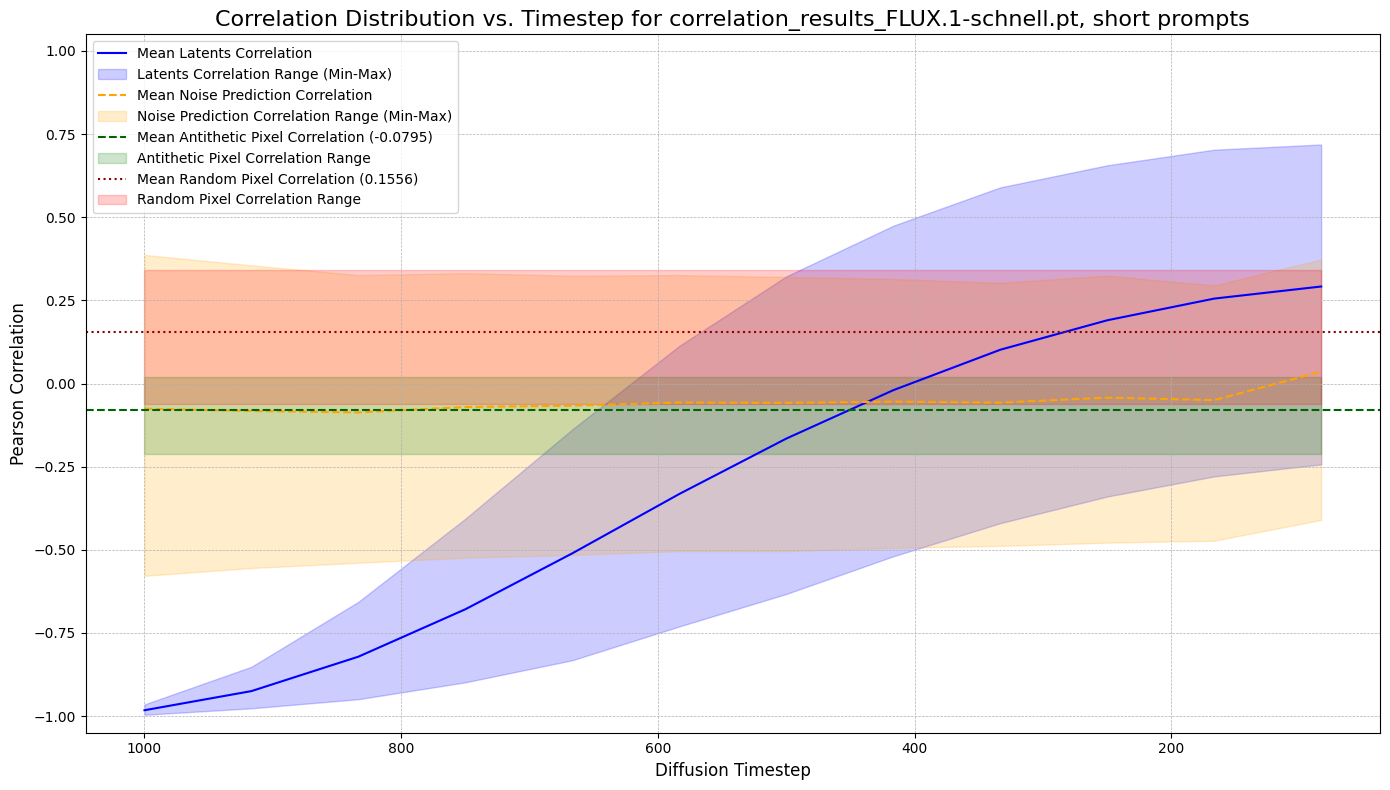

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import argparse
import os

file_path = '/workspace/flux_results/short_prompts/correlation_results_FLUX.1-schnell.pt'
# Load the data from the PyTorch file
data = torch.load(file_path)

# --- Aggregate Data Across All Prompts ---
latents_correlations_by_timestep = defaultdict(list)
noise_pred_correlations_by_timestep = defaultdict(list)
pixel_anti_correlations = []
pixel_random_correlations = []

for prompt, values in data.items():
    if values.get('latents'):
        for t, corr in values['latents']:
            latents_correlations_by_timestep[t.item()].append(corr.item())
    
    if values.get('noise_pred'):
        for t, corr in values['noise_pred']:
            noise_pred_correlations_by_timestep[t.item()].append(corr.item())

    if values.get('pixel_anti') is not None:
        pixel_anti_correlations.append(values['pixel_anti'].item())
        
    if values.get('pixel_random') is not None:
        pixel_random_correlations.append(values['pixel_random'].item())

# --- Calculate Statistics for Plotting ---

# For latents
latents_timesteps = sorted(latents_correlations_by_timestep.keys(), reverse=True)
latents_mean = [np.mean(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_min = [np.min(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_max = [np.max(latents_correlations_by_timestep[t]) for t in latents_timesteps]

# For noise_pred
noise_pred_timesteps = sorted(noise_pred_correlations_by_timestep.keys(), reverse=True)
noise_pred_mean = [np.mean(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_min = [np.min(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_max = [np.max(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]

# --- Create the Plot ---
plt.figure(figsize=(14, 8))

# Plot Latents Correlation Distribution
plt.plot(latents_timesteps, latents_mean, color='blue', linestyle='-', label='Mean Latents Correlation')
plt.fill_between(latents_timesteps, latents_min, latents_max, color='blue', alpha=0.2, label='Latents Correlation Range (Min-Max)')

# Plot Noise Prediction Correlation Distribution
plt.plot(noise_pred_timesteps, noise_pred_mean, color='orange', linestyle='--', label='Mean Noise Prediction Correlation')
plt.fill_between(noise_pred_timesteps, noise_pred_min, noise_pred_max, color='orange', alpha=0.2, label='Noise Prediction Correlation Range (Min-Max)')

# Plot Pixel-Level Correlation Distributions as horizontal bands
if pixel_anti_correlations:
    mean_anti = np.mean(pixel_anti_correlations)
    min_anti = np.min(pixel_anti_correlations)
    max_anti = np.max(pixel_anti_correlations)
    plt.axhline(y=mean_anti, color='darkgreen', linestyle='--', label=f'Mean Antithetic Pixel Correlation ({mean_anti:.4f})')
    plt.fill_between(latents_timesteps, min_anti, max_anti, color='green', alpha=0.2, label='Antithetic Pixel Correlation Range')

if pixel_random_correlations:
    mean_random = np.mean(pixel_random_correlations)
    min_random = np.min(pixel_random_correlations)
    max_random = np.max(pixel_random_correlations)
    plt.axhline(y=mean_random, color='darkred', linestyle=':', label=f'Mean Random Pixel Correlation ({mean_random:.4f})')
    plt.fill_between(latents_timesteps, min_random, max_random, color='red', alpha=0.2, label='Random Pixel Correlation Range')


# --- Configure the Plot ---
plt.title(f'Correlation Distribution vs. Timestep for {os.path.basename(file_path)}, short prompts', fontsize=16)
plt.xlabel('Diffusion Timestep', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.ylim(-1.05, 1.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Reverse the x-axis
ax = plt.gca()
ax.invert_xaxis()

plt.legend(fontsize=10)
plt.tight_layout()

# Save the plot
plot_save_path = f"{os.path.splitext(file_path)[0]}_plot.png"
plt.savefig(plot_save_path)
print(f"Plot saved to {plot_save_path}")
plt.show()

Plot saved to /workspace/flux_results/short_prompts/correlation_results_FLUX.1-dev_plot.png


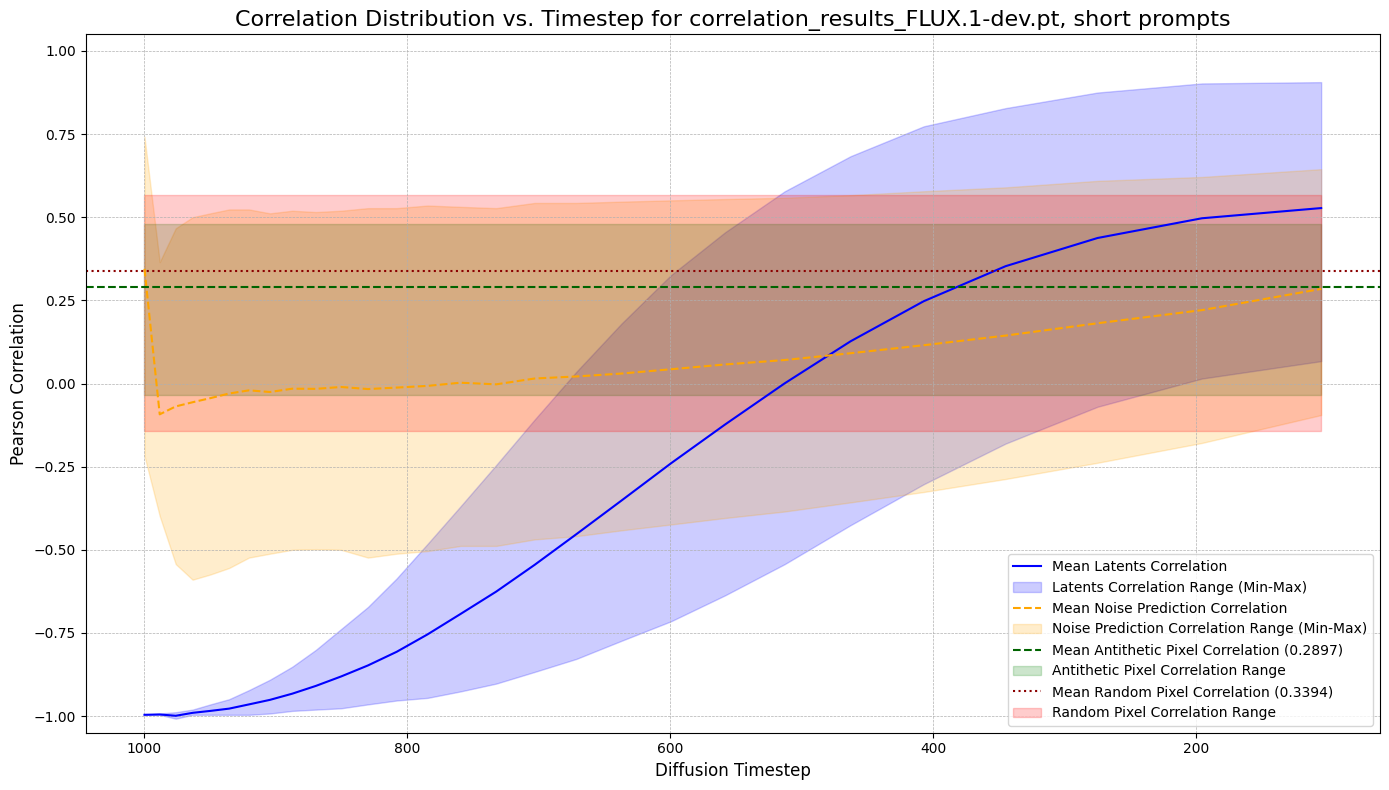

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import argparse
import os

file_path = '/workspace/flux_results/short_prompts/correlation_results_FLUX.1-dev.pt'
# Load the data from the PyTorch file
data = torch.load(file_path)

# --- Aggregate Data Across All Prompts ---
latents_correlations_by_timestep = defaultdict(list)
noise_pred_correlations_by_timestep = defaultdict(list)
pixel_anti_correlations = []
pixel_random_correlations = []

for prompt, values in data.items():
    if values.get('latents'):
        for t, corr in values['latents']:
            latents_correlations_by_timestep[t.item()].append(corr.item())
    
    if values.get('noise_pred'):
        for t, corr in values['noise_pred']:
            noise_pred_correlations_by_timestep[t.item()].append(corr.item())

    if values.get('pixel_anti') is not None:
        pixel_anti_correlations.append(values['pixel_anti'].item())
        
    if values.get('pixel_random') is not None:
        pixel_random_correlations.append(values['pixel_random'].item())

# --- Calculate Statistics for Plotting ---

# For latents
latents_timesteps = sorted(latents_correlations_by_timestep.keys(), reverse=True)
latents_mean = [np.mean(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_min = [np.min(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_max = [np.max(latents_correlations_by_timestep[t]) for t in latents_timesteps]

# For noise_pred
noise_pred_timesteps = sorted(noise_pred_correlations_by_timestep.keys(), reverse=True)
noise_pred_mean = [np.mean(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_min = [np.min(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_max = [np.max(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]

# --- Create the Plot ---
plt.figure(figsize=(14, 8))

# Plot Latents Correlation Distribution
plt.plot(latents_timesteps, latents_mean, color='blue', linestyle='-', label='Mean Latents Correlation')
plt.fill_between(latents_timesteps, latents_min, latents_max, color='blue', alpha=0.2, label='Latents Correlation Range (Min-Max)')

# Plot Noise Prediction Correlation Distribution
plt.plot(noise_pred_timesteps, noise_pred_mean, color='orange', linestyle='--', label='Mean Noise Prediction Correlation')
plt.fill_between(noise_pred_timesteps, noise_pred_min, noise_pred_max, color='orange', alpha=0.2, label='Noise Prediction Correlation Range (Min-Max)')

# Plot Pixel-Level Correlation Distributions as horizontal bands
if pixel_anti_correlations:
    mean_anti = np.mean(pixel_anti_correlations)
    min_anti = np.min(pixel_anti_correlations)
    max_anti = np.max(pixel_anti_correlations)
    plt.axhline(y=mean_anti, color='darkgreen', linestyle='--', label=f'Mean Antithetic Pixel Correlation ({mean_anti:.4f})')
    plt.fill_between(latents_timesteps, min_anti, max_anti, color='green', alpha=0.2, label='Antithetic Pixel Correlation Range')

if pixel_random_correlations:
    mean_random = np.mean(pixel_random_correlations)
    min_random = np.min(pixel_random_correlations)
    max_random = np.max(pixel_random_correlations)
    plt.axhline(y=mean_random, color='darkred', linestyle=':', label=f'Mean Random Pixel Correlation ({mean_random:.4f})')
    plt.fill_between(latents_timesteps, min_random, max_random, color='red', alpha=0.2, label='Random Pixel Correlation Range')


# --- Configure the Plot ---
plt.title(f'Correlation Distribution vs. Timestep for {os.path.basename(file_path)}, short prompts', fontsize=16)
plt.xlabel('Diffusion Timestep', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.ylim(-1.05, 1.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Reverse the x-axis
ax = plt.gca()
ax.invert_xaxis()

plt.legend(fontsize=10)
plt.tight_layout()

# Save the plot
plot_save_path = f"{os.path.splitext(file_path)[0]}_plot.png"
plt.savefig(plot_save_path)
print(f"Plot saved to {plot_save_path}")
plt.show()

Plot saved to /workspace/flux_results/long_prompts/correlation_results_FLUX.1-dev_plot.png


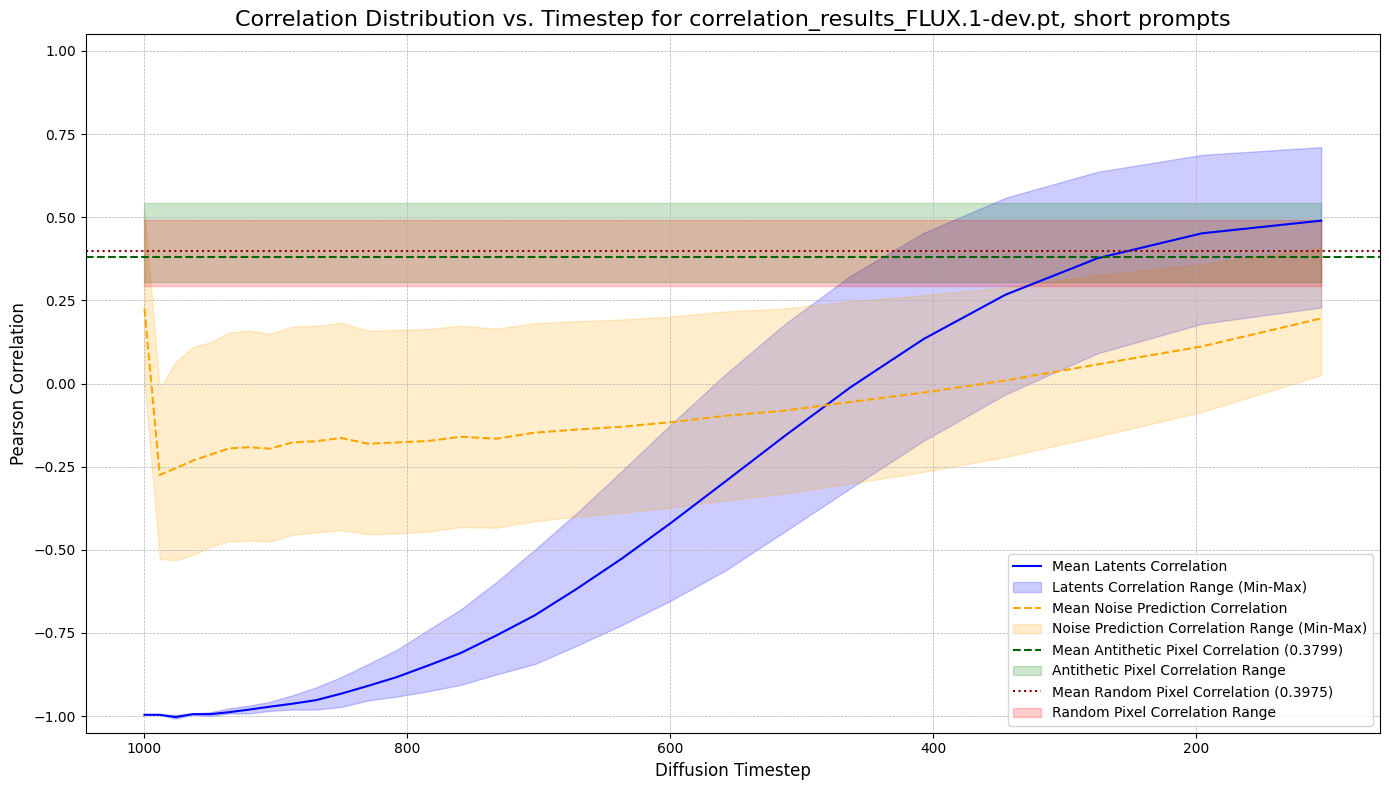

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import argparse
import os

file_path = '/workspace/flux_results/long_prompts/correlation_results_FLUX.1-dev.pt'
# Load the data from the PyTorch file
data = torch.load(file_path)

# --- Aggregate Data Across All Prompts ---
latents_correlations_by_timestep = defaultdict(list)
noise_pred_correlations_by_timestep = defaultdict(list)
pixel_anti_correlations = []
pixel_random_correlations = []

for prompt, values in data.items():
    if values.get('latents'):
        for t, corr in values['latents']:
            latents_correlations_by_timestep[t.item()].append(corr.item())
    
    if values.get('noise_pred'):
        for t, corr in values['noise_pred']:
            noise_pred_correlations_by_timestep[t.item()].append(corr.item())

    if values.get('pixel_anti') is not None:
        pixel_anti_correlations.append(values['pixel_anti'].item())
        
    if values.get('pixel_random') is not None:
        pixel_random_correlations.append(values['pixel_random'].item())

# --- Calculate Statistics for Plotting ---

# For latents
latents_timesteps = sorted(latents_correlations_by_timestep.keys(), reverse=True)
latents_mean = [np.mean(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_min = [np.min(latents_correlations_by_timestep[t]) for t in latents_timesteps]
latents_max = [np.max(latents_correlations_by_timestep[t]) for t in latents_timesteps]

# For noise_pred
noise_pred_timesteps = sorted(noise_pred_correlations_by_timestep.keys(), reverse=True)
noise_pred_mean = [np.mean(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_min = [np.min(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]
noise_pred_max = [np.max(noise_pred_correlations_by_timestep[t]) for t in noise_pred_timesteps]

# --- Create the Plot ---
plt.figure(figsize=(14, 8))

# Plot Latents Correlation Distribution
plt.plot(latents_timesteps, latents_mean, color='blue', linestyle='-', label='Mean Latents Correlation')
plt.fill_between(latents_timesteps, latents_min, latents_max, color='blue', alpha=0.2, label='Latents Correlation Range (Min-Max)')

# Plot Noise Prediction Correlation Distribution
plt.plot(noise_pred_timesteps, noise_pred_mean, color='orange', linestyle='--', label='Mean Noise Prediction Correlation')
plt.fill_between(noise_pred_timesteps, noise_pred_min, noise_pred_max, color='orange', alpha=0.2, label='Noise Prediction Correlation Range (Min-Max)')

# Plot Pixel-Level Correlation Distributions as horizontal bands
if pixel_anti_correlations:
    mean_anti = np.mean(pixel_anti_correlations)
    min_anti = np.min(pixel_anti_correlations)
    max_anti = np.max(pixel_anti_correlations)
    plt.axhline(y=mean_anti, color='darkgreen', linestyle='--', label=f'Mean Antithetic Pixel Correlation ({mean_anti:.4f})')
    plt.fill_between(latents_timesteps, min_anti, max_anti, color='green', alpha=0.2, label='Antithetic Pixel Correlation Range')

if pixel_random_correlations:
    mean_random = np.mean(pixel_random_correlations)
    min_random = np.min(pixel_random_correlations)
    max_random = np.max(pixel_random_correlations)
    plt.axhline(y=mean_random, color='darkred', linestyle=':', label=f'Mean Random Pixel Correlation ({mean_random:.4f})')
    plt.fill_between(latents_timesteps, min_random, max_random, color='red', alpha=0.2, label='Random Pixel Correlation Range')


# --- Configure the Plot ---
plt.title(f'Correlation Distribution vs. Timestep for {os.path.basename(file_path)}, short prompts', fontsize=16)
plt.xlabel('Diffusion Timestep', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.ylim(-1.05, 1.05)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Reverse the x-axis
ax = plt.gca()
ax.invert_xaxis()

plt.legend(fontsize=10)
plt.tight_layout()

# Save the plot
plot_save_path = f"{os.path.splitext(file_path)[0]}_plot.png"
plt.savefig(plot_save_path)
print(f"Plot saved to {plot_save_path}")
plt.show()